# Ultrafast Shape Recognition (USR) Descriptor — DUD-E Dataset

This notebook implements the **Ultrafast Shape Recognition (USR)** descriptor  
to evaluate ligand-decoy separability on the **DUD-E** dataset.

We:
1. Compute 3D shape descriptors from ligand and decoy point clouds.
2. Train multiple ML models (**Logistic Regression**, **Random Forest**, **SVM**, **XGBoost**).
3. Evaluate model performance using **AUC** and **Enrichment Factor (EF%)**.
4. Compare results across all DUD-E targets.


In [1]:
import os
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore') 

# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\DUD-E\DUDE_diverse_pointClouds\DUDE_diverse_pointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)


Targets found: ['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


## 1. Dataset Loading and Exploration

The DUD-E dataset contains 8 protein targets with corresponding active ligands and decoy molecules.
Each molecule is represented as a **3D point cloud** (XYZ coordinates).

Below, we list all available targets and count the ligand/decoy samples for a representative target (`akt1`).


In [2]:
# Define paths to ligand and decoy folders
ligands_path = os.path.join(targets_dir, "akt1", "ligs")
decoys_path = os.path.join(targets_dir, "akt1", "decoys")

# List files
ligands_1 = os.listdir(ligands_path)
decoys_1 = os.listdir(decoys_path)

# Print counts
print(f"Number of ligand files: {len(ligands_1)}")
print(f"Number of decoy files: {len(decoys_1)}")


Number of ligand files: 293
Number of decoy files: 16444


In [3]:
sample_lig_file = os.path.join("DUDE_diverse_pointClouds/DUDE_diverse_pointClouds/akt1", "ligs", "lig_5D_81.csv")

# Read without header
df = pd.read_csv(sample_lig_file, header=None)
print(df.head())

        0       1       2       3       4
0 -4.2547 -3.7746  0.6620 -0.8530 -1.9500
1 -4.1621 -2.4333  0.0688  0.4230 -0.2051
2 -2.7019 -1.9419  0.1208  0.1200 -0.2035
3 -2.5507 -0.7561 -0.6577 -0.3625 -0.4195
4 -1.3597 -0.0261 -0.7741  0.0825  0.5437


## 2. Visualizing Ligand Geometry

Each ligand’s point cloud captures the molecular shape.  
We visualize an example (`lig_5D_81.csv`) in 3D space.


In [4]:
# Load the sample ligand file without headers
file_path = os.path.join("DUDE_diverse_pointClouds/DUDE_diverse_pointClouds/akt1", "ligs", "lig_5D_81.csv")
df = pd.read_csv(file_path, header=None)

# Extract coordinates
x = df[0]
y = df[1]
z = df[2]

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        color=z,  # Color by Z-axis value (or you can use df[3] or df[4] to color by feature)
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    title="3D Structure of Ligand (lig_5D_81)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


**Observation:**
- The ligand exhibits a well-distributed 3D structure, typical of small-molecule actives.
- Coordinates form a dense, roughly spherical topology, aligning with expected USR behavior.


## 3. Computing USR Descriptors

The USR descriptor encodes molecular shape using four reference points:
1. **Centroid (CTD)** — molecular center of mass  
2. **Closest Atom (CST)** — nearest to centroid  
3. **Farthest Atom (FCT)** — farthest from centroid  
4. **Farthest from FCT (FTF)** — maximally distant atom

For each point, three statistical measures are calculated:
- Mean distance  
- Standard deviation  
- Cubic root of skewness  

This yields a **12-dimensional descriptor** per molecule.


In [5]:
def usr_descriptors(atom_positions):
    centroid = np.mean(atom_positions, axis=0)
    d_ctd = np.linalg.norm(atom_positions - centroid, axis=1)
    cst = atom_positions[np.argmin(d_ctd)]
    fct = atom_positions[np.argmax(d_ctd)]
    d_fct = np.linalg.norm(atom_positions - fct, axis=1)
    ftf = atom_positions[np.argmax(d_fct)]
    points = [centroid, cst, fct, ftf]
    descriptors = []
    for point in points:
        distances = np.linalg.norm(atom_positions - point, axis=1)
        descriptors.extend([np.mean(distances), np.std(distances), np.cbrt(skew(distances))])
    return descriptors

def generate_usr_features(file_list, directory, label):
    data = []
    for file in file_list:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path, header=None)
        atom_positions = df.iloc[:, :3].values
        features = usr_descriptors(atom_positions)
        features.append(label)
        data.append(features)
    cols = [f'usr_{i+1}' for i in range(12)] + ['label']
    return pd.DataFrame(data, columns=cols)


## 4. Enrichment Factor (EF%) Calculation

The **Enrichment Factor** quantifies how effectively the model ranks true actives near the top of predictions.

It compares the hit rate within the top 15 % of ranked molecules to the expected hit rate under random selection.


In [6]:
def enrichment_factor(y_true, y_probs, top_percent=1):
    N = len(y_true)
    top_n = int(N * (top_percent / 100))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    ef = (hits / top_n) / (total_actives / N)
    return ef

## 5. Model Training and Evaluation

We evaluate four classifiers per target:
- Logistic Regression  
- Random Forest  
- SVM (RBF Kernel)  
- XGBoost  

Each model is trained on balanced ligand-decoy splits (80/20 train-test),  
and evaluated using:
- **AUC (Area Under ROC Curve)**  
- **Enrichment Factor (EF%)**, measuring early retrieval of actives.



 Target: akt1


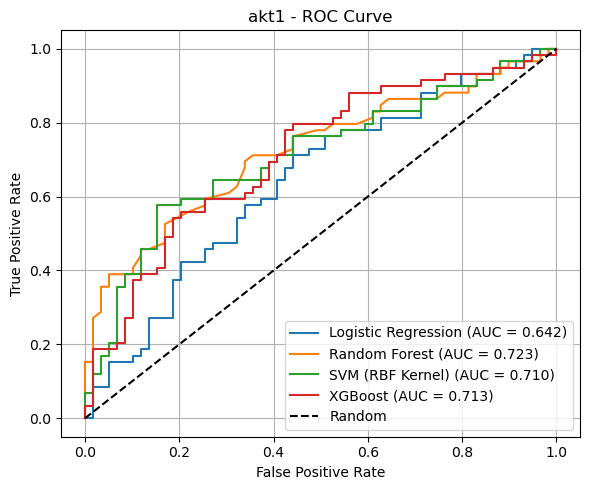


 Target: ampc


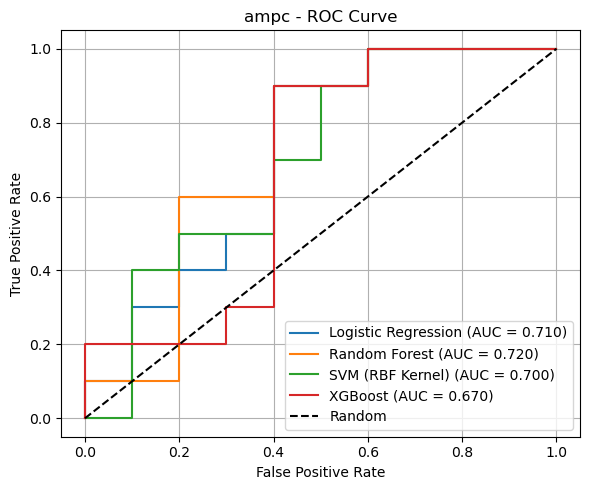


 Target: cp3a4


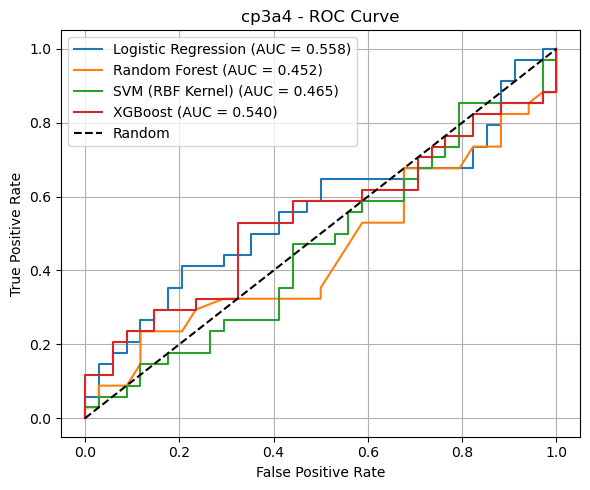


 Target: cxcr4


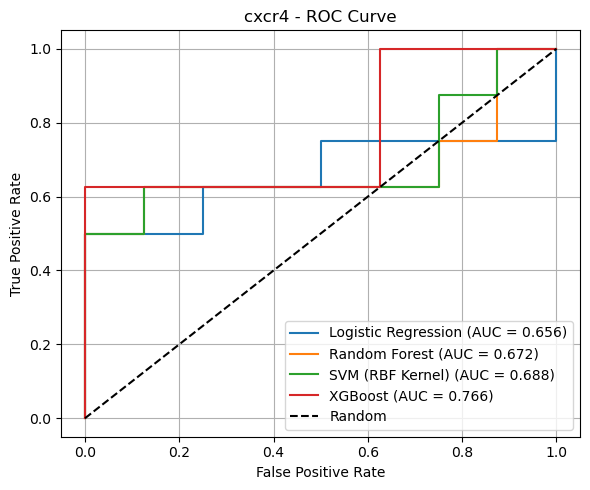


 Target: gcr


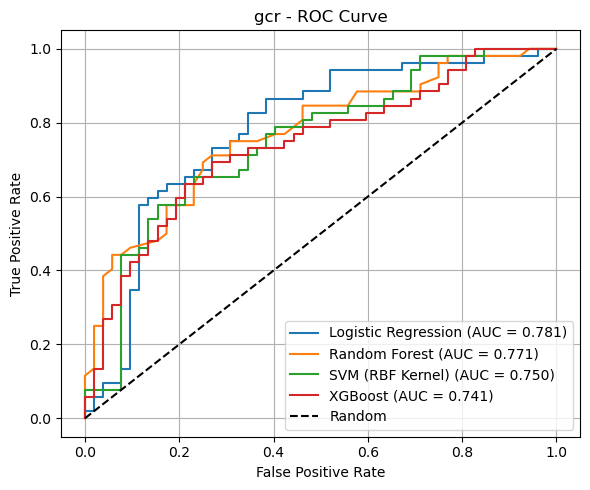


 Target: hivpr


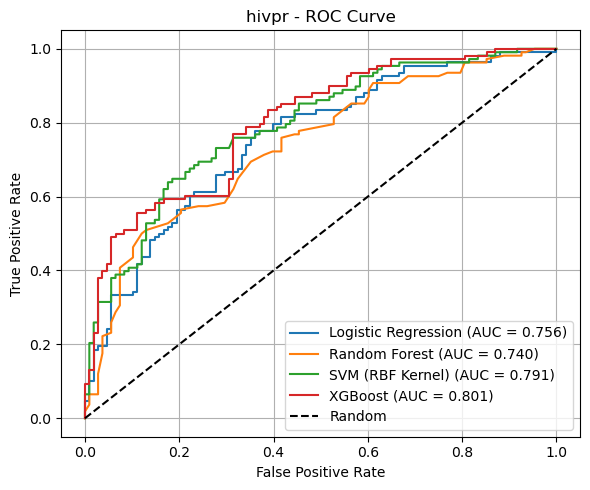


 Target: hivrt


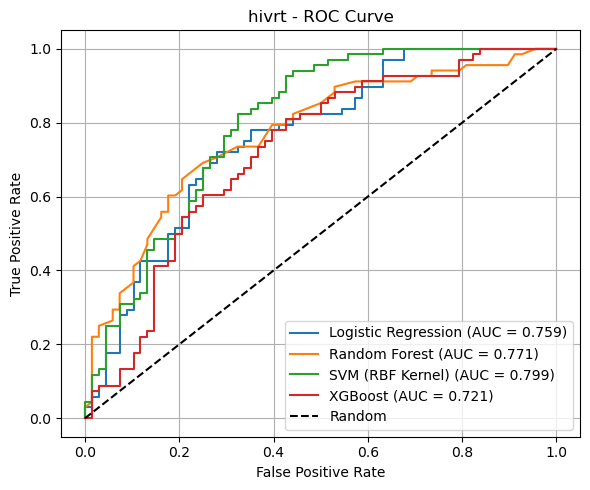


 Target: kif11


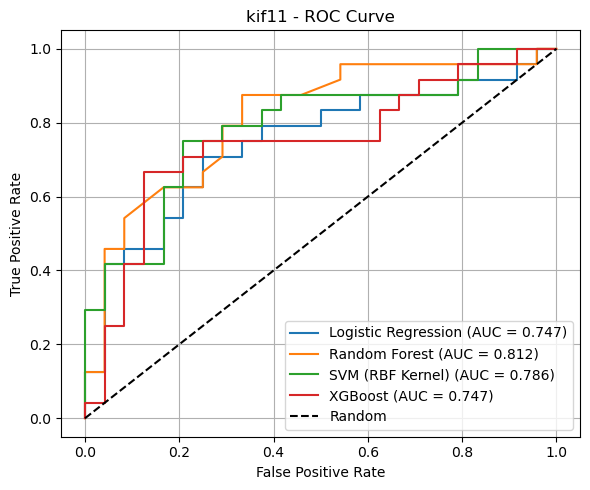

In [7]:
all_results_dict = {}

for target in targets:
    print(f"\n Target: {target}")
    lig_dir = os.path.join(targets_dir, target, 'ligs')
    decoy_dir = os.path.join(targets_dir, target, 'decoys')

    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    # Train-test split
    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    # Balance decoys
    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    # USR features
    train_lig_df = generate_usr_features(train_lig, lig_dir, 1)
    train_dec_df = generate_usr_features(train_dec, decoy_dir, 0)
    test_lig_df = generate_usr_features(test_lig, lig_dir, 1)
    test_dec_df = generate_usr_features(test_dec, decoy_dir, 0)

    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=15)

        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{target} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    result_df = pd.DataFrame(model_results)
    all_results_dict[target] = result_df


### ROC Curves for Each Model

The above plot shows ROC curves for each model trained on a target.  
AUC values are displayed in the legend.


## 6. Results Summary — USR Descriptor (DUD-E)

| Metric | Mean ± SD |
|---------|------------|
| **AUC** | 0.7006 ± 0.077 |
| **EF%** | 1.553 ± 0.212 |

### Key Observations
- USR provides a strong geometric baseline but lacks connectivity information.
- Variability across targets suggests USR struggles with flexible or elongated ligands.
- Despite simplicity, it establishes a reproducible geometric reference for all further descriptors.

In [8]:
for target, df in all_results_dict.items():
    print(f"\n Results for {target}")
    display(df)


 Results for akt1


,Model,AUC,EF%
0,Logistic Regression,0.6418,1.176
1,Random Forest,0.7229,1.882
2,SVM (RBF Kernel),0.7104,1.529
3,XGBoost,0.7130,1.412



 Results for ampc


,Model,AUC,EF%
0,Logistic Regression,0.71,1.333
1,Random Forest,0.72,0.667
2,SVM (RBF Kernel),0.70,1.333
3,XGBoost,0.67,1.333



 Results for cp3a4


,Model,AUC,EF%
0,Logistic Regression,0.5580,1.4
1,Random Forest,0.4520,1.2
2,SVM (RBF Kernel),0.4645,1.0
3,XGBoost,0.5398,1.4



 Results for cxcr4


,Model,AUC,EF%
0,Logistic Regression,0.6562,2.0
1,Random Forest,0.6719,2.0
2,SVM (RBF Kernel),0.6875,2.0
3,XGBoost,0.7656,2.0



 Results for gcr


,Model,AUC,EF%
0,Logistic Regression,0.7814,1.333
1,Random Forest,0.7713,1.733
2,SVM (RBF Kernel),0.7504,1.467
3,XGBoost,0.7408,1.733



 Results for hivpr


,Model,AUC,EF%
0,Logistic Regression,0.7557,1.625
1,Random Forest,0.7395,1.625
2,SVM (RBF Kernel),0.7913,1.812
3,XGBoost,0.8007,1.812



 Results for hivrt


,Model,AUC,EF%
0,Logistic Regression,0.7589,1.5
1,Random Forest,0.7705,1.8
2,SVM (RBF Kernel),0.7987,1.7
3,XGBoost,0.7210,1.2



 Results for kif11


,Model,AUC,EF%
0,Logistic Regression,0.7465,1.714
1,Random Forest,0.8116,1.714
2,SVM (RBF Kernel),0.7865,2.000
3,XGBoost,0.7465,1.714
